In [63]:
# defining globals
job_info_file_partial_path = 'plugin=job_table/metric=job_info_marconi100/a_0_filter123_singlenode.csv'
total_power_file_partial_path = 'plugin=ipmi_pub/metric=total_power/a_0_filter123_singlenode.csv'
column_dtypes = {'resv_name': object, 'wait4switch': object}

### Checking that start time and end time difference results in runtime for all rows in all datasets

In [64]:
import os
import pandas as pd

# Specify the root directory where your HPC job log dataset is located
root_directory = '../data'

# Iterate through each month folder
for month_folder in os.listdir(root_directory):
    month_path = os.path.join(root_directory, month_folder)

    if os.path.isdir(month_path):
        # Construct the file path based on the pattern
        file_path = os.path.join(month_path, job_info_file_partial_path)

        if os.path.exists(file_path):
            print(f'Analyzing invalid rows existence in {month_folder}:')

            df = pd.read_csv(file_path, dtype=column_dtypes)
                        
            # Filter rows where start_time + runtime is not equal to end_time
            invalid_rows = df[((pd.to_datetime(df['start_time']) + pd.to_timedelta(df['run_time'], unit='s')) == pd.to_datetime(df['end_time']))]

            # Print the invalid rows
            if not invalid_rows.empty:
                print(invalid_rows)
                print('\n---\n')
            else:
                print("All rows have consistent start time, end time and runtime values.")

Analyzing invalid rows existence in year_month=22-05:
       accrue_time  alloc_node  alloc_sid  array_job_id  array_max_tasks  \
0              NaN         NaN        NaN       3915009              NaN   
1              NaN         NaN        NaN       1492464              NaN   
2              NaN         NaN        NaN       6098620              NaN   
3              NaN         NaN        NaN       5198558              NaN   
4              NaN         NaN        NaN       4243491              NaN   
...            ...         ...        ...           ...              ...   
62493          NaN         NaN        NaN       4981560              NaN   
62494          NaN         NaN        NaN       4670239              NaN   
62495          NaN         NaN        NaN       2277991              NaN   
62496          NaN         NaN        NaN       1756028              NaN   
62497          NaN         NaN        NaN       3154185              NaN   

       array_task_id  array_task_

/tmp/ipykernel_1519044/2446428068.py:18: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, dtype=column_dtypes)


       accrue_time  alloc_node  alloc_sid  array_job_id  array_max_tasks  \
0              NaN         NaN        NaN       2782294              NaN   
1              NaN         NaN        NaN       4009596              NaN   
2              NaN         NaN        NaN       2737271              NaN   
3              NaN         NaN        NaN        366394              NaN   
4              NaN         NaN        NaN        121539              NaN   
...            ...         ...        ...           ...              ...   
39506          NaN         NaN        NaN        273759              NaN   
39507          NaN         NaN        NaN       4005614              NaN   
39508          NaN         NaN        NaN       2325532              NaN   
39509          NaN         NaN        NaN       3543649              NaN   
39510          NaN         NaN        NaN        746152              NaN   

       array_task_id  array_task_str  array_task_throttle  assoc_id  \
0               

### Merging IPMI dataset with job_table dataset by job ID for month 22-08

In [65]:
# Setting the chunk size for merging dataframes without using excessive memory
chunk_size = 10000

# Creating the path for the specific month's data
month_path = os.path.join(root_directory, 'year_month=22-08')

# Creating full file paths for the job information and total power data files
job_info_file_path = os.path.join(month_path, job_info_file_partial_path)
total_power_file_path = os.path.join(month_path, total_power_file_partial_path)

# Reading the job information and total power data files in chunks
job_info_chunks = pd.read_csv(job_info_file_path, dtype=column_dtypes, chunksize=chunk_size)
total_power_chunks = pd.read_csv(total_power_file_path, chunksize=chunk_size)

# Dataframe to store the merged data
merged_df = pd.DataFrame()

# Iterating through the chunks of job information and total power data, merging them on the 'job_id' column
for job_info_chunk, total_power_chunk in zip(job_info_chunks, total_power_chunks):
    # Performing an inner merge on the 'job_id' column
    merged_df_chunk = pd.merge(job_info_chunk, total_power_chunk, on='job_id', how='inner')
    
    # Concatenating the merged chunk to the overall merged dataframe
    merged_df = pd.concat([merged_df, merged_df_chunk], ignore_index=True)

# Print the number of rows in each DataFrame
print(f"Number of rows in job_info DataFrame: {job_info_chunk.shape[0]}")
print(f"Number of rows in total_power DataFrame: {total_power_chunk.shape[0]}")
print(f"Number of rows in merged DataFrame: {merged_df.shape[0]}")
print(merged_df.loc[merged_df["start_time"].astype("datetime64[ns]").idxmax(), "timestamp"])
print(merged_df.loc[merged_df["start_time"].astype("datetime64[ns]").idxmin(), "timestamp"])

Number of rows in job_info DataFrame: 5976
Number of rows in total_power DataFrame: 10000
Number of rows in merged DataFrame: 12914
2022-08-08 19:33:20+00:00
2022-08-07 22:50:00+00:00


### Visualizing the time series of power consumption for the longest running job in Marconi during 22-08

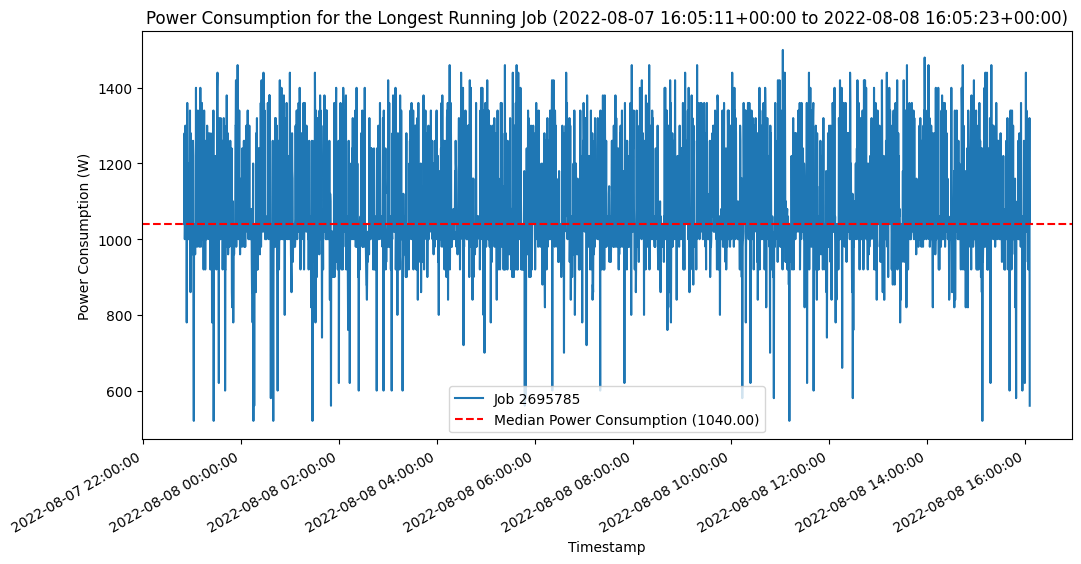

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

timestamp_col = 'timestamp'
runtime_col = 'run_time'
power_col = 'value'

# Find the rows corresponding to the longest running job
longest_running_job_row = merged_df.loc[merged_df[runtime_col].idxmax()]

# Extract the information
start_time = longest_running_job_row['start_time']
end_time = longest_running_job_row['end_time']

# DataFrame containing the timestamp and power consumption values for the job with the longest run time
longest_running_job_power = merged_df[merged_df['job_id'] == longest_running_job_row['job_id']][[timestamp_col, power_col]]

# Calculate the median of power consumption
median_power_consumption = longest_running_job_power[power_col].median()

# Convert timestamp values to datetime objects
longest_running_job_power[timestamp_col] = pd.to_datetime(longest_running_job_power[timestamp_col])

# Plot the time series of power consumption for the longest running job
plt.figure(figsize=(12, 6))
plt.plot(longest_running_job_power[timestamp_col], longest_running_job_power[power_col], label=f'Job {longest_running_job_row["job_id"]}')
plt.axhline(y=median_power_consumption, color='r', linestyle='--', label=f'Median Power Consumption ({median_power_consumption:.2f})')
plt.title(f'Power Consumption for the Longest Running Job ({start_time} to {end_time})')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')

# Format the timestamp labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.legend()
plt.show()

### Applying Fourier Transform to the time series of power consumption for the longest running job

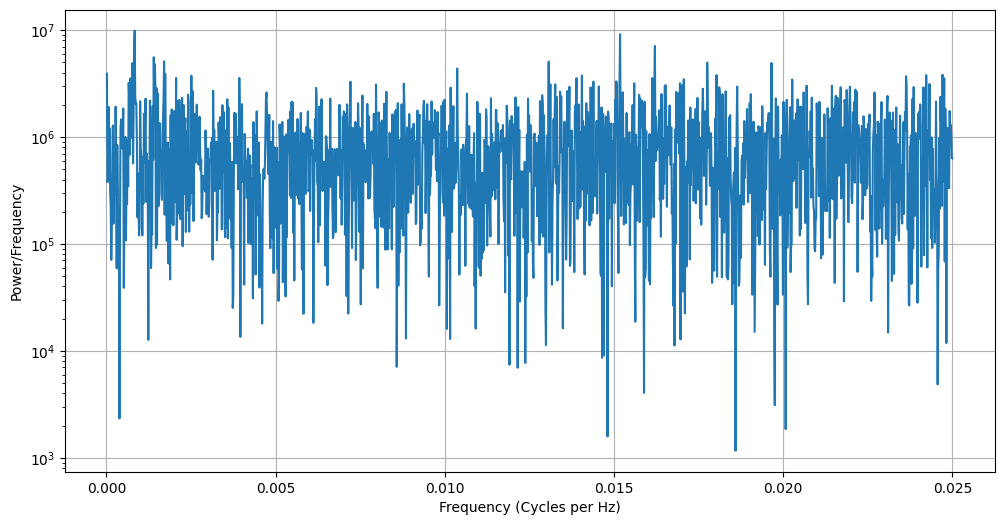

In [67]:
import numpy as np
import pandas as pd
from scipy.signal import periodogram

# ensure timestamps are sorted
longest_running_job_power = longest_running_job_power.sort_values(timestamp_col)

# power consumption values
power_values = longest_running_job_power[power_col].values

# Fourier transform to get periodogram using 1/20 as sampling freq since all timestamps are 20 secs from each other
frequencies, power_spectrum = periodogram(power_values, fs=1/20)

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies[1:], power_spectrum[1:])
plt.xlabel('Frequency (Cycles per Hz)')
plt.ylabel('Power/Frequency')
plt.grid(True)
plt.show()

For example, if there's a strong periodic pattern in the time series that repeats every 24 hours, we might see a peak in the periodogram at a frequency corresponding to 1 cycle per 24 hours (the inverse of the period).

### Setting a threshold and finding periodicity hints

In [68]:
from scipy.signal import find_peaks

max_spectral_powers = []

# Generate permuted sequences, calculate periodogram, record max spectral powers
for _ in range(100):
    permuted_sequence = np.random.permutation(power_values)
    _, spectrum = periodogram(permuted_sequence, fs=1/20)
    max_spectral_powers.append(np.max(spectrum))

threshold = np.sort(max_spectral_powers)[-99]
peaks, _ = find_peaks(power_spectrum, height=threshold)

# extract frequencies corresponding to peaks
period_hints_in_minutes = (1 / frequencies[peaks]) / 60
print("Periods in Minutes:", period_hints_in_minutes)

Periods in Minutes: [19.91025641 11.90038314  1.09791446  1.02813638]


With the periodicity hint found (~20 minutes), we can zoom in the plot to show the power consumption patter of the job during 20 minutes, because that patter is likely repeating itself over the course of the job's whole execution time.

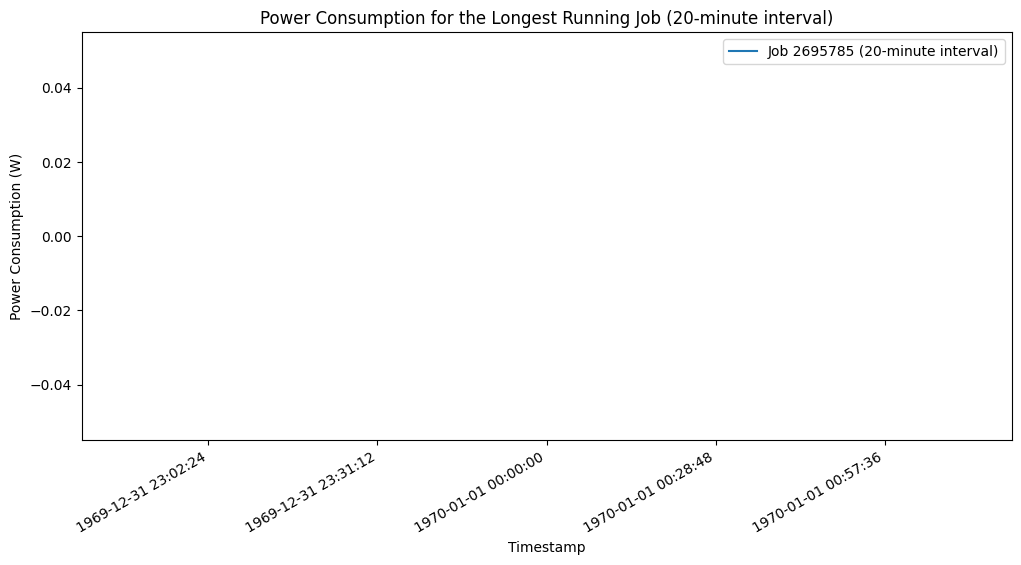

In [111]:
# Plot the power consumption over a 20-minute interval
interval_data = longest_running_job_power[
    (longest_running_job_power[timestamp_col] >= start_time) &
    (longest_running_job_power[timestamp_col] <= pd.to_datetime(start_time) + pd.Timedelta(minutes=20))
]

plt.figure(figsize=(12, 6))
plt.plot(interval_data[timestamp_col], interval_data[power_col], label=f'Job {longest_running_job_row["job_id"]} (20-minute interval)')
plt.title(f'Power Consumption for the Longest Running Job (20-minute interval)')
plt.xlabel('Timestamp')
plt.ylabel('Power Consumption (W)')

# Format the timestamp labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels for better readability

plt.legend()
plt.show()


### Visualizing the time series of total power consumption in Marconi during the month of August

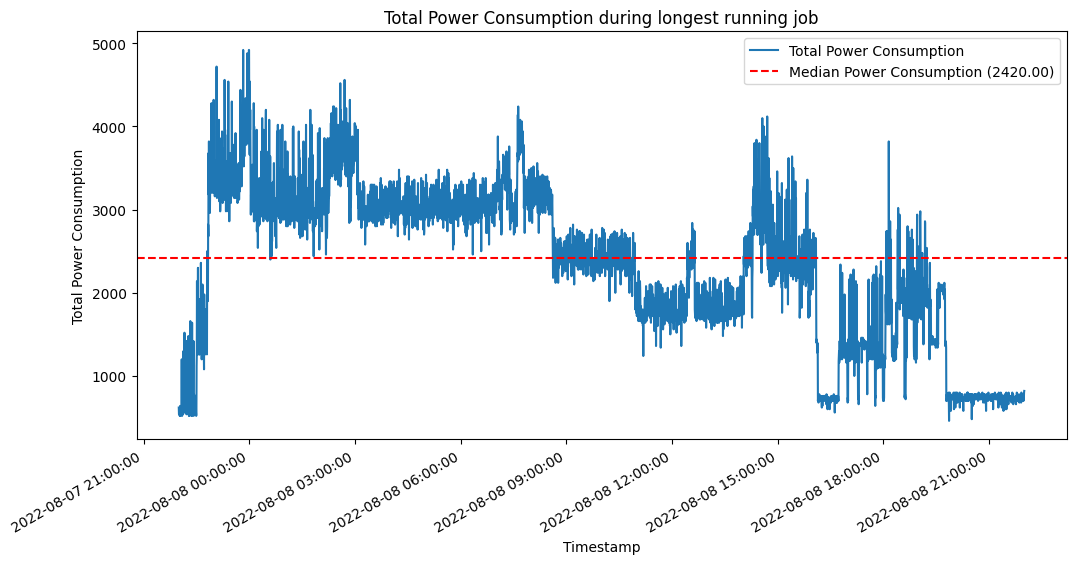

In [69]:
power_data = merged_df[[timestamp_col, power_col]]

# Group by timestamp and sum the power consumption values
total_power_by_timestamp = power_data.groupby(timestamp_col)[power_col].sum().reset_index()

median_total_power = total_power_by_timestamp[power_col].median()

total_power_by_timestamp[timestamp_col] = pd.to_datetime(total_power_by_timestamp[timestamp_col])

plt.figure(figsize=(12, 6))
plt.plot(total_power_by_timestamp[timestamp_col], total_power_by_timestamp[power_col], label='Total Power Consumption')
plt.axhline(y=median_total_power, color='r', linestyle='--', label=f'Median Power Consumption ({median_total_power:.2f})')
plt.title('Total Power Consumption during longest running job')
plt.xlabel('Timestamp')
plt.ylabel('Total Power Consumption')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
